In [ ]:
pip install numpy matplotlib pandas requests japanize-matplotlib setuptools pyserial requests

In [2]:
import serial
import csv
import os
from datetime import datetime
import threading
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import requests
import time
import threading
from collections import deque
from IPython.display import display, clear_output

/Users/oosugakaito/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [103]:
file_name=25

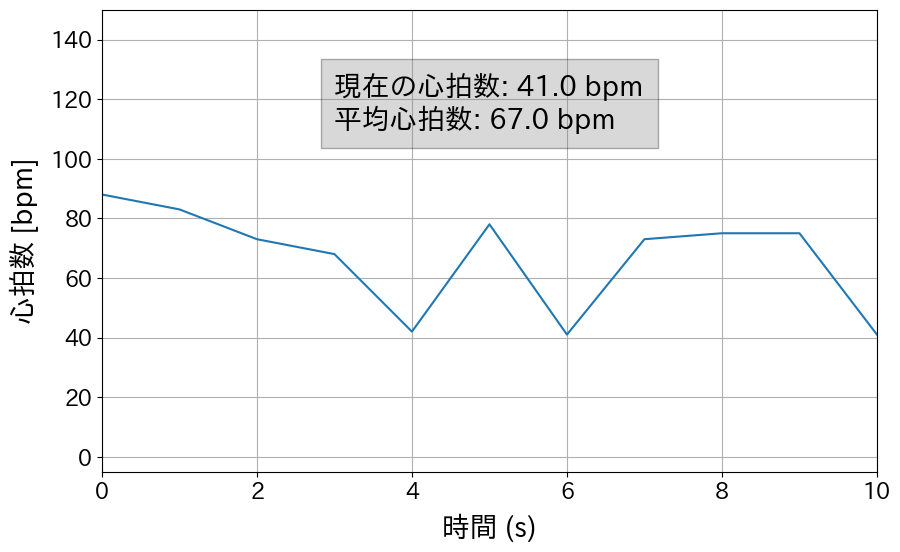

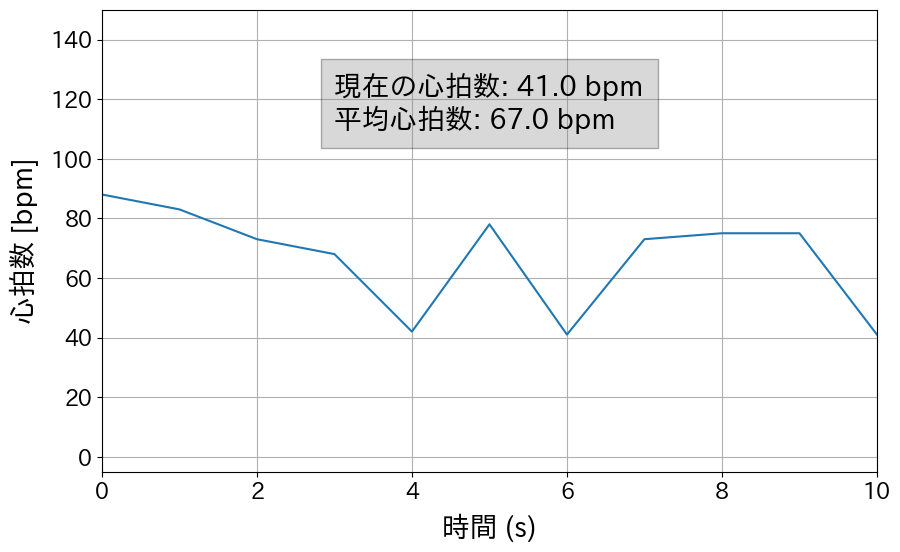

In [104]:
student_id = 26 # 学生番号の下3桁
url = f"http://192.168.{student_id}.2"
num = 11
interval_success = 0.5
interval_error = 1.0
queue = deque([0] * num)
values = []
times = []
max_errors = 100
error_count = 0
i = 0

plt.figure(figsize=(10, 6))

while i < num and error_count < max_errors:
    start = time.perf_counter()
    try:
        with requests.get(
            url,
            timeout=(2.0, 5.0), # (接続タイムアウト, 応答タイムアウト)
            headers={"Connection": "close"}
        ) as response:
            response.raise_for_status()
            value = response.json()['value']
            if value<40 or value>130:
                success=False
            else:
                success=True
    except Exception as e:
        error_count += 1
        print(f"データ取得エラー({error_count}/{max_errors}):再試行します →", e)
        success = False

    if success:
        error_count = 0
        queue.popleft()
        queue.append(value)
        values.append(value)
        times.append(time.time())
        i += 1
        
        clear_output(wait=True)
        plt.cla()
        plt.plot(list(queue))
        plt.grid()
        plt.xlim(0, 10)
        plt.ylim(-5, 150)
        plt.xlabel("時間 (s)", fontsize=20, labelpad=8)
        plt.ylabel("心拍数 [bpm]", fontsize=20, labelpad=8)
        plt.tick_params(labelsize=16)
        
        current = queue[-1]
        avg = np.mean(values)
        plt.text(
            3, 110,
            f"現在の心拍数: {current} bpm\n平均心拍数: {avg:.1f} bpm",
            bbox={'facecolor': 'gray', 'alpha': 0.3, 'pad': 10},
            fontsize=20
        )
        display(plt.gcf())
        
        elapsed = time.perf_counter() - start
        rest = interval_success - elapsed
        if rest > 0:
            time.sleep(rest)
    else:
        time.sleep(interval_error)

df = pd.DataFrame({'heartrate': np.array(values)})
df.to_csv(f'{file_name}th.csv', index=False)
plt.savefig(f"{file_name}th.png")

=== Bland-Altman Analysis ===
平均差 (バイアス): -3.89 bpm
上限値 (+1.96 SD): 4.48 bpm
下限値 (-1.96 SD): -12.26 bpm


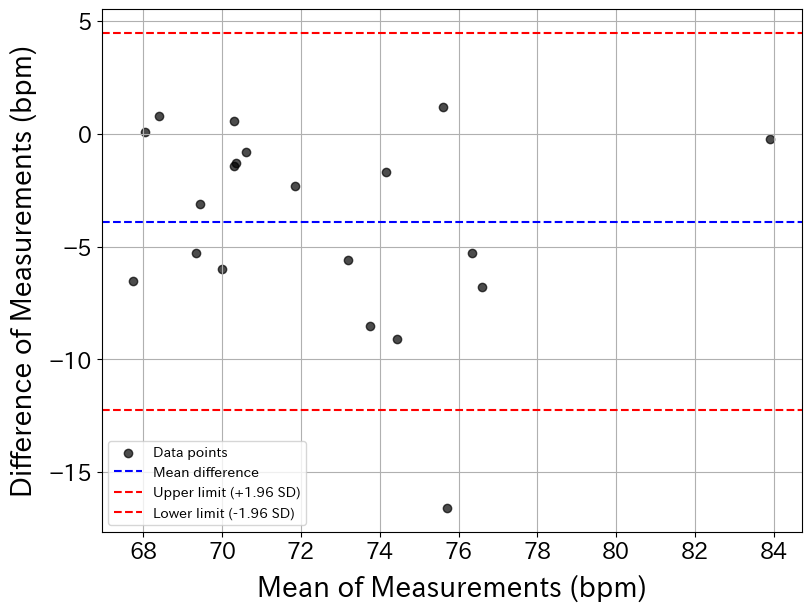

In [6]:
df = pd.read_csv('data_myself/Ave.csv')
commercial = df["Commercial"].values # 市販の脈拍計
developed = df["Developed"].values # 開発した脈拍計
mean_values = (commercial + developed) / 2 # 平均値
differences = commercial - developed # 差分
mean_diff = np.mean(differences) # 差分の平均
std_diff = np.std(differences) # 差分の標準偏差
upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff
plt.figure(figsize=(8, 6), layout='constrained')
plt.scatter(mean_values, differences, color='k', alpha=0.7, label='Data points')
plt.axhline(mean_diff, color='blue', linestyle='--', label='Mean difference')
plt.axhline(upper_limit, color='red', linestyle='--', label='Upper limit (+1.96 SD)')
plt.axhline(lower_limit, color='red', linestyle='--', label='Lower limit (-1.96 SD)')
plt.xlabel('Mean of Measurements (bpm)', fontsize=20, labelpad=8)
plt.ylabel('Difference of Measurements (bpm)', fontsize=20, labelpad=8)
plt.tick_params(labelsize=16)
plt.legend()
plt.grid(True)
print("=== Bland-Altman Analysis ===")
print(f"平均差 (バイアス): {mean_diff:.2f} bpm")
print(f"上限値 (+1.96 SD): {upper_limit:.2f} bpm")
print(f"下限値 (-1.96 SD): {lower_limit:.2f} bpm")